In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Step 1:

Consider a N=1000 sample from `mean = [1,2]` and `cov = [[0.5,0.3],[0.3,0.3]]`. 

Write code that generates such a sample and visualize it on the 2-D plane

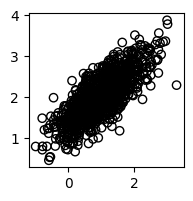

In [9]:
def get_samples(N = 1000):
    samples = np.random.multivariate_normal([1,2],[[0.5,0.3],[0.3,0.3]], size = (N,))
    return samples

samples = get_samples(1000)
plt.scatter(samples[:,0],samples[:,1], marker = 'o', facecolor = 'none', edgecolor = 'k')
plt.gcf().set_size_inches(2,2)

## Step 2: - The Bijection and its Inverse

Write two PyTorch functions that applies a affine transformation y = Ax + b and its inverse. Hint: `torch.einsum(..)` makes it easy to do.

In [13]:
def apply_affine(x,A,b):
    return torch.einsum('ij,bj',A,x) + b

def apply_inverse(y,A,b):
    Ainv = torch.linalg.inv(A)
    return torch.einsum('ij,bj',Ainv,y - b)

## Step 3 - The Jacobian

Derive an expression for the Jacobian $\frac{\partial y}{\partial x}$ and write a function that computes the log abs determinant of the Jacobian $|\mathrm{det} J|$ for a given affine transform



In [28]:
def log_det_affine(A,b):
    detJ = torch.abs(torch.linalg.det(A))
    return torch.log(detJ)

In [29]:
latent_dist = torch.distributions.Normal(0,1)
def log_prob_sample(samples,A,b):
    mapped = apply_inverse(samples, A, b)
    probs = latent_dist.log_prob(mapped).sum(axis=-1) - log_det_affine(A,b)
    return probs

## Step 4 - Evaluating $p(y)$

Using the Change of Variables Formula and the `torch.distributions` module write a function that evaluates the log-probability of a sample under the distribution

$$ p(y = f_{A,b}(x)) $$ 

where $$ p(x) = \mathrm{Normal}(0,1) $$

In [32]:
latent_dist = torch.distributions.Normal(0,1)
def log_prob_sample(y,A,b):
    x = apply_inverse(y, A, b)
    probs = latent_dist.log_prob(x).sum(axis=-1) - log_det_affine(A,b)
    return probs

## Step 5

Create a PyTorch module that has Affine Transformation parameters (A,b) and provides two methods: 1) "log_prob" for a batch of samples and "generate" to generate transformed samples starting from a base distribution



In [36]:
class MyFlow(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.A = torch.nn.Parameter(torch.randn(2,2))
        self.b = torch.nn.Parameter(torch.randn(2))
        
    def log_prob(self,samples):
        return log_prob_sample(samples, self.A,self.b)
    
    def generate(self,N):
        return apply_affine(latent_dist.sample((N,2)), self.A,self.b)

## Step 6

Train a 2D Normalizing Flow q(x) using an affine transformation f(x) = Ax + b. Train it to maximize the likelihood. As you train, plot the current state of the model

i 16.324094772338867


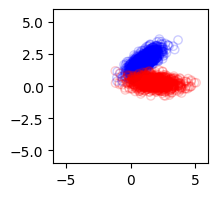

i 2.9256513118743896


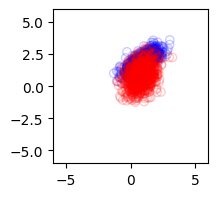

i 1.9962722063064575


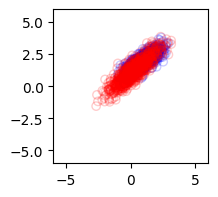

i 1.7035373449325562


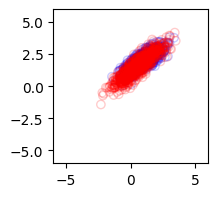

i 1.459303617477417


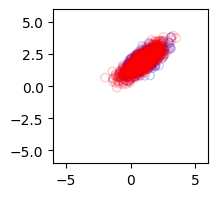

In [47]:
samples = get_samples()

def plot(model):
    samples = get_samples()
    fake = model.generate(1000).detach()
    plt.scatter(samples[:,0],samples[:,1], marker  = 'o', facecolor = 'none', edgecolor = 'b', alpha = 0.2)
    plt.scatter(fake[:,0],fake[:,1], marker = 'o', facecolor = 'none', edgecolor = 'r', alpha = 0.2)
    plt.gcf().set_size_inches(2,2)
    plt.xlim(-6,6)
    plt.ylim(-6,6)
    
def train_flow(model):
    opt = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(5000):
        v1 = model.log_prob(torch.tensor(samples).float())
        loss = -v1.mean()
        loss.backward()
        opt.step()
        opt.zero_grad()
        if i % 1000 == 0:
            print('i',float(loss))
            plot(model)
            plt.show()

model = MyFlow()
train_flow(model)

In [48]:
!open .